In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.mane_utils import *
from scripts.plotting import *

In [2]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = '../'+expand(config['data']['ab'], species='human')[0]
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
read_annot = '../'+expand(config['data']['read_annot'], species='human')[0]
t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]
major_isos = '../'+expand(config['data']['major_isos'], species='human', obs_col='sample')[0]
pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]
ref_t_metadata = '../'+expand(config['ref']['t_info'], species='human')[0]
ref_g_metadata = '../'+expand(config['ref']['g_info'], species='human')[0]


sr_ab = '../'+config['sr']['ab']


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_lib_meta = '../'+expand(config['data']['meta'], species='mouse')[0]
m_ab = '../'+expand(config['data']['ab'], species='mouse')[0]
m_filt_ab = '../'+expand(config['data']['filt_ab'], species='mouse')[0]
m_read_annot = '../'+expand(config['data']['read_annot'], species='mouse')[0]
m_t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='mouse')[0]
m_swan_file = '../'+expand(config['data']['sg'], species='mouse')[0]
m_cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='mouse')[0]
m_pi_tpm_table = '../'+expand(config['data']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_major_isos = '../'+expand(config['data']['major_isos'], species='mouse', obs_col='sample')[0]
m_pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='mouse')[0]
m_ref_t_metadata = '../'+expand(config['ref']['t_info'], species='mouse')[0]
m_ref_g_metadata = '../'+expand(config['ref']['g_info'], species='mouse')[0]


mouse_ver = 'vM25_cerberus'

In [29]:
sg = swan.read(m_swan_file)

Read in graph from ../data/mouse/swan_graph.p


In [37]:
test = sorted(sg.adata.obs['sample'].unique().tolist())
test

['adrenal',
 'adrenal_10d',
 'adrenal_14d',
 'adrenal_18-20mo',
 'adrenal_25d',
 'adrenal_2mo',
 'adrenal_36d',
 'adrenal_4d',
 'c2c12_myoblast',
 'c2c12_myotube',
 'cortex',
 'cortex_14d',
 'cortex_18-20mo',
 'cortex_2mo',
 'f1219',
 'forelimb_e11',
 'forelimb_e13',
 'gastroc_10d',
 'gastroc_14d',
 'gastroc_18-20mo',
 'gastroc_25d',
 'gastroc_2mo',
 'gastroc_36d',
 'gastroc_4d',
 'heart_14d',
 'heart_18-20mo',
 'heart_2mo',
 'hippocampus',
 'hippocampus_14d',
 'hippocampus_18-20mo',
 'hippocampus_2mo']

In [11]:
df = sg.adata.obs.copy(deep=True)

In [12]:
temp = df.loc[(df.general_tissue_cell_type.isin(['hippocampus', 'cortex']))&\
              (df.genotype.isin(['b6n', '5xfad']))]
inds = temp.index

In [13]:
sg.adata = sg.adata[inds, :]
sg.gene_adata = sg.gene_adata[inds, :]
sg.tss_adata = sg.tss_adata[inds, :]
sg.tes_adata = sg.tes_adata[inds, :]
sg.ic_adata = sg.ic_adata[inds, :]

sc.pp.filter_genes(sg.adata, min_cells=1)
sc.pp.filter_genes(sg.gene_adata, min_cells=1)
sc.pp.filter_genes(sg.tss_adata, min_cells=1)
sc.pp.filter_genes(sg.tes_adata, min_cells=1)
sc.pp.filter_genes(sg.ic_adata, min_cells=1)

/Users/fairliereese/miniconda3/envs/base_clone/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:224: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [19]:
# filter out novel genes and spike ins
df = sg.gene_adata.var.copy(deep=True)
print(len(df.index))
df = df.loc[~df.gid.str.contains('SIRV')]
df = df.loc[~df.gid.str.contains('ERCC')]
df = df.loc[~df.gid.str.contains('pike')]
df = df.loc[~df.gid.str.contains('ENCODE')]
print(len(df.index))
inds = df.index
sg.gene_adata = sg.gene_adata[:, inds]

121996
27268


In [20]:
# set colors
import matplotlib as mpl

region_cmap = {'hippocampus': 'deeppink',
               'cortex': 'darkviolet'}
sg.set_metadata_colors('general_tissue_cell_type', region_cmap)

cond_cmap = {'5xfad': 'purple', 
             'b6n': 'lightpink'}
sg.set_metadata_colors('genotype', cond_cmap)

sex_cmap = {'f': 'green', 'm': 'yellow'}
sg.set_metadata_colors('sex', sex_cmap)

/Users/fairliereese/miniconda3/envs/base_clone/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [21]:
sg.save_graph('swan_modelad')

Saving graph as swan_modelad.p


In [4]:
sg = swan.read('swan_modelad.p')

Read in graph from swan_modelad.p


In [6]:
temp = sg.adata.obs.copy(deep=True)
temp = temp[['sample', 'genotype', 'sex', 'ENCODE_experiment_id']].drop_duplicates().reset_index(drop=True)
temp

,sample,genotype,sex,ENCODE_experiment_id
0,cortex,b6n,f,ENCSR131CES
1,cortex,5xfad,f,ENCSR280VKU
2,hippocampus,5xfad,f,ENCSR060OTU
3,cortex,b6n,m,ENCSR644GDT
4,hippocampus,b6n,m,ENCSR214HSG
5,cortex,b6n,m,ENCSR340GWV
6,hippocampus,5xfad,m,ENCSR404AEI
7,cortex,5xfad,m,ENCSR674BKT
8,hippocampus,b6n,f,ENCSR411ZHA
9,hippocampus,b6n,m,ENCSR926OGQ


In [6]:
# die tests for tss, isoform, and tes
die_df = pd.DataFrame()
for feat in ['tss', 'iso', 'tes']:
    df, _ = sg.die_gene_test(kind=feat,
                             obs_col='genotype', 
                             verbose=True)
    df['feat'] = feat
    die_df = pd.concat([die_df, df], axis=0)

Testing for DIE for each gene: 100%|██████████| 27188/27188 [06:59<00:00, 73.84it/s]

In [8]:
die_df.to_csv('die_results.tsv', sep='\t')

In [1]:
import swan_vis as swan

In [2]:
sg = swan.read('swan_modelad.p')

Read in graph from swan_modelad.p


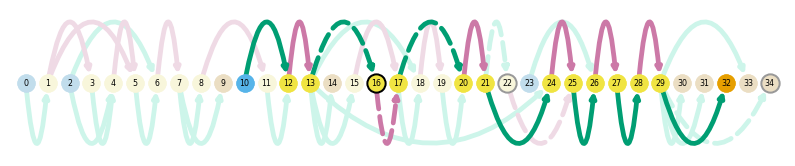

In [3]:
sg.plot_transcript_path('ENSMUSG00000059326[4,9,1]', indicate_novel=True)

In [20]:
die_df = pd.read_csv('die_results.tsv', sep='\t')

In [23]:
die_df.head()
temp = die_df.loc[(die_df.dpi>=10)&(die_df.adj_p_val<=0.05)]

In [25]:
temp.loc[temp.gname=='Lsp1']

,Unnamed: 0,gid,p_val,dpi,pos_iso_1,pos_iso_2,pos_iso_1_dpi,pos_iso_2_dpi,neg_iso_1,neg_iso_2,neg_iso_1_dpi,neg_iso_2_dpi,adj_p_val,gname,feat
983,983,ENSMUSG00000018819,1.496273e-12,47.027733,ENSMUSG00000018819_4,ENSMUSG00000018819_9,34.933465,10.303444,ENSMUSG00000018819_2,NaN,-47.027733,NaN,6.018592e-11,Lsp1,tss
13388,5303,ENSMUSG00000018819,2.643357e-13,51.355551,"ENSMUSG00000018819[4,15,1]","ENSMUSG00000018819[9,15,1]",23.025745,10.303444,"ENSMUSG00000018819[2,2,1]","ENSMUSG00000018819[2,4,1]",-39.454047,-11.901504,7.691031e-12,Lsp1,iso


In [24]:
for feat in ['tss', 'iso', 'tes']:
    temp2 = temp.loc[temp.feat==feat]
    temp2.to_csv(f'{feat}_die.tsv', sep='\t')
    n_die = len(temp.loc[temp.feat==feat])
    print(f'There are {n_die} {feat} switching events between black 6 and 5xFAD')

There are 696 tss switching events between black 6 and 5xFAD
There are 1676 iso switching events between black 6 and 5xFAD
There are 965 tes switching events between black 6 and 5xFAD


In [9]:
def make_reports(sg, g):
        sg.gen_report(g,
                      f'figures/{g}',
                      cmap='viridis',
                      browser=True,
                      transcript_col='tname',
                      metadata_cols=['genotype', 'sex', 'sample'],
                      datasets={'genotype': sg.adata.obs.genotype.unique().tolist(),
                                'sex': sg.adata.obs.sex.unique().tolist(),
                                'sample': sg.adata.obs['sample'].unique().tolist()})
        sg.gen_report(g,
                      f'figures/{g}',
                      cmap='magma',
                      transcript_col='tname',
                      browser=True,
                      layer='pi',
                      metadata_cols=['genotype', 'sex', 'sample'],
                      datasets={'genotype': sg.adata.obs.genotype.unique().tolist(),
                                'sex': sg.adata.obs.sex.unique().tolist(),
                                'sample': sg.adata.obs['sample'].unique().tolist()})

In [7]:
def make_reports_2(sg, g):
        sg.gen_report(g,
                      f'figures/{g}',
                      novelty=True,
                      cmap='viridis',
                      browser=True,
                      transcript_col='tname',
                      metadata_cols=['genotype', 'sample'],
                      groupby=['genotype', 'sample'],
                      datasets={'genotype': sg.adata.obs.genotype.unique().tolist(),
                                'sample': sg.adata.obs['sample'].unique().tolist()})
        sg.gen_report(g,
                      f'figures/{g}',
                      novelty=True,
                      cmap='viridis',
                      transcript_col='tname',
                      browser=True,
                      layer='pi',
                      metadata_cols=['genotype', 'sample'],
                      groupby=['genotype', 'sample'],
                      display_numbers=True,
                      datasets={'genotype': sg.adata.obs.genotype.unique().tolist(),
                                'sample': sg.adata.obs['sample'].unique().tolist()})

In [11]:
genes = ['Csf2ra']
for g in genes:
    make_reports(sg, g)


Plotting transcripts for ENSMUSG00000059326
Saving transcript path graph for ENSMUSG00000059326[2,2,1] as figures/Csf2ra_browser_ENSMUSG00000059326[2,2,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,9,1] as figures/Csf2ra_browser_ENSMUSG00000059326[4,9,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,11,1] as figures/Csf2ra_browser_ENSMUSG00000059326[4,11,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,13,1] as figures/Csf2ra_browser_ENSMUSG00000059326[4,13,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,12,1] as figures/Csf2ra_browser_ENSMUSG00000059326[4,12,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,9,7] as figures/Csf2ra_browser_ENSMUSG00000059326[4,9,7]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,4,1] as figures/Csf2ra_browser_ENSMUSG00000059326[4,4,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[1,1,1] as figures/Csf2ra_browser_ENSMUSG00000059326[1,1,1

In [25]:
sg.adata.obs['sample'].unique()

['cortex', 'hippocampus']
Categories (2, object): ['cortex', 'hippocampus']

In [23]:
sg.adata.obs.loc[sg.adata.obs.genotype=='b6n']

,dataset,total_counts,ENCODE_file_id,ENCODE_experiment_id,sample,sample_display,general_tissue_cell_type,fig1_tissue_label,age,adult,sex,genotype,tissue_or_cell_line,sample_color_hex_code,matching_human_samples,reads_post_talon,genotype_sample
index,,,,,,,,,,,,,,,,,
cortex_wt_f_1_1,cortex_wt_f_1_1,1639318.0,ENCFF505EPC,ENCSR131CES,cortex,Cortex,cortex,cortex,NaN,True,f,b6n,tissue,#634273,"['brain', 'pgp1_excite_neuron', 'pgp1_astro']",2016725,b6n_cortex
cortex_wt_f_1_2,cortex_wt_f_1_2,1854086.0,ENCFF525AQR,ENCSR131CES,cortex,Cortex,cortex,cortex,NaN,True,f,b6n,tissue,#634273,"['brain', 'pgp1_excite_neuron', 'pgp1_astro']",2259132,b6n_cortex
cortex_wt_m_2_2,cortex_wt_m_2_2,2227137.0,ENCFF149EOM,ENCSR644GDT,cortex,Cortex,cortex,cortex,NaN,True,m,b6n,tissue,#634273,"['brain', 'pgp1_excite_neuron', 'pgp1_astro']",2740617,b6n_cortex
cortex_wt_m_2_1,cortex_wt_m_2_1,2081288.0,ENCFF405HLV,ENCSR644GDT,cortex,Cortex,cortex,cortex,NaN,True,m,b6n,tissue,#634273,"['brain', 'pgp1_excite_neuron', 'pgp1_astro']",2538854,b6n_cortex
hippocampus_wt_m_1_1,hippocampus_wt_m_1_1,1016911.0,ENCFF428AJY,ENCSR214HSG,hippocampus,Hippocampus,hippocampus,hippocampus,NaN,True,m,b6n,tissue,#9a3c4f,"['brain', 'pgp1_excite_neuron', 'pgp1_astro']",1366252,b6n_hippocampus
cortex_wt_m_1_1,cortex_wt_m_1_1,937905.0,ENCFF839PZB,ENCSR340GWV,cortex,Cortex,cortex,cortex,NaN,True,m,b6n,tissue,#634273,"['brain', 'pgp1_excite_neuron', 'pgp1_astro']",1306424,b6n_cortex
cortex_wt_m_1_2,cortex_wt_m_1_2,867495.0,ENCFF773TTA,ENCSR340GWV,cortex,Cortex,cortex,cortex,NaN,True,m,b6n,tissue,#634273,"['brain', 'pgp1_excite_neuron', 'pgp1_astro']",1304133,b6n_cortex
hippocampus_wt_m_1_2,hippocampus_wt_m_1_2,934551.0,ENCFF648REP,ENCSR214HSG,hippocampus,Hippocampus,hippocampus,hippocampus,NaN,True,m,b6n,tissue,#9a3c4f,"['brain', 'pgp1_excite_neuron', 'pgp1_astro']",1330153,b6n_hippocampus
hippocampus_wt_f_1_2,hippocampus_wt_f_1_2,1601372.0,ENCFF041PKK,ENCSR411ZHA,hippocampus,Hippocampus,hippocampus,hippocampus,NaN,True,f,b6n,tissue,#9a3c4f,"['brain', 'pgp1_excite_neuron', 'pgp1_astro']",2000242,b6n_hippocampus


In [18]:
genes = ['Csf1', 'Lsp1', 'Irf1', 'Csf2ra']
for g in genes:
    make_reports_2(sg, g)


Plotting transcripts for ENSMUSG00000014599
Saving transcript path graph for ENSMUSG00000014599[2,1,1] as figures/Csf1_browser_ENSMUSG00000014599[2,1,1]_path.png
Saving transcript path graph for ENSMUSG00000014599[1,4,1] as figures/Csf1_browser_ENSMUSG00000014599[1,4,1]_path.png
Saving transcript path graph for ENSMUSG00000014599[1,1,1] as figures/Csf1_browser_ENSMUSG00000014599[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000014599[1,2,2] as figures/Csf1_browser_ENSMUSG00000014599[1,2,2]_path.png
Saving transcript path graph for ENSMUSG00000014599[1,11,1] as figures/Csf1_browser_ENSMUSG00000014599[1,11,1]_path.png
Saving transcript path graph for ENSMUSG00000014599[1,1,7] as figures/Csf1_browser_ENSMUSG00000014599[1,1,7]_path.png
Saving transcript path graph for ENSMUSG00000014599[2,4,1] as figures/Csf1_browser_ENSMUSG00000014599[2,4,1]_path.png
Saving transcript path graph for ENSMUSG00000014599[1,10,1] as figures/Csf1_browser_ENSMUSG00000014599[1,10,1]_path.png
Saving 

In [8]:
g = 'Csf1'
make_reports(sg, g)


Plotting transcripts for ENSMUSG00000014599
Saving transcript path graph for ENSMUSG00000014599[2,1,1] as figures/Csf1_novel_ENSMUSG00000014599[2,1,1]_path.png
Saving transcript path graph for ENSMUSG00000014599[1,4,1] as figures/Csf1_novel_ENSMUSG00000014599[1,4,1]_path.png
Saving transcript path graph for ENSMUSG00000014599[1,1,1] as figures/Csf1_novel_ENSMUSG00000014599[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000014599[1,2,2] as figures/Csf1_novel_ENSMUSG00000014599[1,2,2]_path.png
Saving transcript path graph for ENSMUSG00000014599[1,11,1] as figures/Csf1_novel_ENSMUSG00000014599[1,11,1]_path.png
Saving transcript path graph for ENSMUSG00000014599[2,4,1] as figures/Csf1_novel_ENSMUSG00000014599[2,4,1]_path.png
Saving transcript path graph for ENSMUSG00000014599[1,1,7] as figures/Csf1_novel_ENSMUSG00000014599[1,1,7]_path.png
Saving transcript path graph for ENSMUSG00000014599[1,10,1] as figures/Csf1_novel_ENSMUSG00000014599[1,10,1]_path.png
Saving transcript path 

In [9]:
g = 'Clu'
make_reports(sg, g)


Plotting transcripts for ENSMUSG00000022037
Saving transcript path graph for ENSMUSG00000022037[2,1,1] as figures/Clu_novel_ENSMUSG00000022037[2,1,1]_path.png
Saving transcript path graph for ENSMUSG00000022037[1,1,1] as figures/Clu_novel_ENSMUSG00000022037[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000022037[6,17,1] as figures/Clu_novel_ENSMUSG00000022037[6,17,1]_path.png
Saving transcript path graph for ENSMUSG00000022037[3,14,1] as figures/Clu_novel_ENSMUSG00000022037[3,14,1]_path.png
Saving transcript path graph for ENSMUSG00000022037[6,18,1] as figures/Clu_novel_ENSMUSG00000022037[6,18,1]_path.png
Saving transcript path graph for ENSMUSG00000022037[5,16,1] as figures/Clu_novel_ENSMUSG00000022037[5,16,1]_path.png
Saving transcript path graph for ENSMUSG00000022037[4,15,1] as figures/Clu_novel_ENSMUSG00000022037[4,15,1]_path.png
Saving transcript path graph for ENSMUSG00000022037[2,11,1] as figures/Clu_novel_ENSMUSG00000022037[2,11,1]_path.png
Saving transcript path 

In [10]:
g = 'Irf1'
make_reports(sg, g)


Plotting transcripts for ENSMUSG00000018899
Saving transcript path graph for ENSMUSG00000018899[1,1,1] as figures/Irf1_novel_ENSMUSG00000018899[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000018899[2,2,1] as figures/Irf1_novel_ENSMUSG00000018899[2,2,1]_path.png
Saving transcript path graph for ENSMUSG00000018899[2,12,1] as figures/Irf1_novel_ENSMUSG00000018899[2,12,1]_path.png
Saving transcript path graph for ENSMUSG00000018899[2,13,1] as figures/Irf1_novel_ENSMUSG00000018899[2,13,1]_path.png
Generating report for ENSMUSG00000018899

Plotting transcripts for ENSMUSG00000018899
Saving transcript path graph for ENSMUSG00000018899[1,1,1] as figures/Irf1_browser_ENSMUSG00000018899[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000018899[2,2,1] as figures/Irf1_browser_ENSMUSG00000018899[2,2,1]_path.png
Saving transcript path graph for ENSMUSG00000018899[2,12,1] as figures/Irf1_browser_ENSMUSG00000018899[2,12,1]_path.png
Saving transcript path graph for ENSMUSG00000

In [11]:
g = 'Lamp2'
make_reports(sg, g)


Plotting transcripts for ENSMUSG00000016534
Saving transcript path graph for ENSMUSG00000016534[1,1,1] as figures/Lamp2_novel_ENSMUSG00000016534[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000016534[1,3,3] as figures/Lamp2_novel_ENSMUSG00000016534[1,3,3]_path.png
Saving transcript path graph for ENSMUSG00000016534[1,2,2] as figures/Lamp2_novel_ENSMUSG00000016534[1,2,2]_path.png
Saving transcript path graph for ENSMUSG00000016534[1,2,6] as figures/Lamp2_novel_ENSMUSG00000016534[1,2,6]_path.png
Saving transcript path graph for ENSMUSG00000016534[1,9,3] as figures/Lamp2_novel_ENSMUSG00000016534[1,9,3]_path.png
Saving transcript path graph for ENSMUSG00000016534[1,10,3] as figures/Lamp2_novel_ENSMUSG00000016534[1,10,3]_path.png
Saving transcript path graph for ENSMUSG00000016534[1,8,1] as figures/Lamp2_novel_ENSMUSG00000016534[1,8,1]_path.png
Saving transcript path graph for ENSMUSG00000016534[2,4,4] as figures/Lamp2_novel_ENSMUSG00000016534[2,4,4]_path.png
Generating report

In [30]:
g = 'Lsp1'
make_reports(sg, g)


Plotting transcripts for ENSMUSG00000018819
Saving transcript path graph for ENSMUSG00000018819[2,2,1] as figures/Lsp1_novel_ENSMUSG00000018819[2,2,1]_path.png
Saving transcript path graph for ENSMUSG00000018819[2,4,1] as figures/Lsp1_novel_ENSMUSG00000018819[2,4,1]_path.png
Saving transcript path graph for ENSMUSG00000018819[4,15,1] as figures/Lsp1_novel_ENSMUSG00000018819[4,15,1]_path.png
Saving transcript path graph for ENSMUSG00000018819[2,2,2] as figures/Lsp1_novel_ENSMUSG00000018819[2,2,2]_path.png
Saving transcript path graph for ENSMUSG00000018819[9,15,1] as figures/Lsp1_novel_ENSMUSG00000018819[9,15,1]_path.png
Saving transcript path graph for ENSMUSG00000018819[4,6,1] as figures/Lsp1_novel_ENSMUSG00000018819[4,6,1]_path.png
Saving transcript path graph for ENSMUSG00000018819[4,6,2] as figures/Lsp1_novel_ENSMUSG00000018819[4,6,2]_path.png
Saving transcript path graph for ENSMUSG00000018819[2,3,1] as figures/Lsp1_novel_ENSMUSG00000018819[2,3,1]_path.png
Saving transcript path 

In [5]:
g = 'Lsp1'

sg.gen_report(g,
              f'figures/{g}_gb',
              novelty=True,
              cmap='magma',
              transcript_col='tname',
              browser=True,
              layer='pi',
              metadata_cols=['genotype'],
              display_numbers=True,
              groupby='genotype')


Plotting transcripts for ENSMUSG00000018819
Saving transcript path graph for ENSMUSG00000018819[2,2,1] as figures/Lsp1_gb_browser_ENSMUSG00000018819[2,2,1]_path.png
Saving transcript path graph for ENSMUSG00000018819[2,4,1] as figures/Lsp1_gb_browser_ENSMUSG00000018819[2,4,1]_path.png
Saving transcript path graph for ENSMUSG00000018819[4,15,1] as figures/Lsp1_gb_browser_ENSMUSG00000018819[4,15,1]_path.png
Saving transcript path graph for ENSMUSG00000018819[9,15,1] as figures/Lsp1_gb_browser_ENSMUSG00000018819[9,15,1]_path.png
Saving transcript path graph for ENSMUSG00000018819[2,2,2] as figures/Lsp1_gb_browser_ENSMUSG00000018819[2,2,2]_path.png
Saving transcript path graph for ENSMUSG00000018819[4,6,1] as figures/Lsp1_gb_browser_ENSMUSG00000018819[4,6,1]_path.png
Saving transcript path graph for ENSMUSG00000018819[2,3,1] as figures/Lsp1_gb_browser_ENSMUSG00000018819[2,3,1]_path.png
Saving transcript path graph for ENSMUSG00000018819[4,6,2] as figures/Lsp1_gb_browser_ENSMUSG00000018819

In [35]:
# sg.tss_adata.X = sg.tss_adata.layers['tpm']
# sc.pp.log1p(sg.tss_adata)
# sg.tss_adata.layers['log_norm'] = sg.tss_adata.X.copy()

In [12]:
import scanpy as sc

sc.set_figure_params(figsize=(4,3), dpi_save=700)
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42


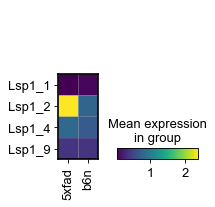

In [13]:
tsss = sg.tss_adata.var.loc[sg.tss_adata.var.gname=='Lsp1'].tss_name.tolist()
sc.pl.matrixplot(sg.tss_adata,
                 var_names=tsss,
                 groupby='genotype',
                 layer='tpm',
                 log=True,
                 gene_symbols='tss_name',
                 swap_axes=True,
                 save='tss_lsp_genotype_matrix.pdf')


In [53]:
temp.loc[temp.feat=='iso'].sort_values(by='dpi', ascending=False).head(20)

,Unnamed: 0,gid,p_val,dpi,pos_iso_1,pos_iso_2,pos_iso_1_dpi,pos_iso_2_dpi,neg_iso_1,neg_iso_2,neg_iso_1_dpi,neg_iso_2_dpi,adj_p_val,gname,feat
14248,6163,ENSMUSG00000070304,0.000000e+00,98.345152,"ENSMUSG00000070304[4,3,1]","ENSMUSG00000070304[1,1,2]",97.973656,0.371496,"ENSMUSG00000070304[2,3,1]","ENSMUSG00000070304[5,3,1]",-42.150138,-31.147539,0.000000e+00,Scn2b,iso
8990,905,ENSMUSG00000062661,0.000000e+00,98.100890,"ENSMUSG00000062661[3,3,4]","ENSMUSG00000062661[3,3,1]",97.032639,1.068249,"ENSMUSG00000062661[1,1,1]","ENSMUSG00000062661[1,4,3]",-96.405974,-1.694915,0.000000e+00,Ncs1,iso
15411,7326,ENSMUSG00000020431,1.981335e-70,97.864772,"ENSMUSG00000020431[4,3,1]","ENSMUSG00000020431[1,1,1]",90.769234,7.095538,"ENSMUSG00000020431[3,3,1]","ENSMUSG00000020431[3,3,4]",-50.889675,-46.975090,5.238478e-68,Adcy1,iso
10890,2805,ENSMUSG00000028868,4.666700e-19,97.297302,"ENSMUSG00000028868[1,8,6]",NaN,97.297302,NaN,"ENSMUSG00000028868[8,7,2]","ENSMUSG00000028868[1,1,2]",-88.235298,-9.062003,2.005527e-17,Wasf2,iso
17606,9521,ENSMUSG00000022114,4.811576e-65,96.370975,"ENSMUSG00000022114[2,2,1]","ENSMUSG00000022114[2,2,3]",95.026878,1.344086,"ENSMUSG00000022114[1,1,1]","ENSMUSG00000022114[3,3,2]",-65.322586,-31.048390,1.125354e-62,Spry2,iso
10541,2456,ENSMUSG00000039853,1.317463e-20,94.623657,"ENSMUSG00000039853[1,1,1]",NaN,94.623656,NaN,"ENSMUSG00000039853[1,1,7]",NaN,-94.623657,NaN,6.210457e-19,Trim14,iso
18135,10050,ENSMUSG00000022521,6.555587e-13,90.909093,"ENSMUSG00000022521[11,3,10]","ENSMUSG00000022521[11,3,1]",50.000000,25.862068,"ENSMUSG00000022521[10,3,1]","ENSMUSG00000022521[10,3,10]",-81.818184,-9.090909,1.849862e-11,Crebbp,iso
12499,4414,ENSMUSG00000035674,3.617884e-24,89.577465,"ENSMUSG00000035674[2,7,2]","ENSMUSG00000035674[1,1,1]",88.169014,0.281690,"ENSMUSG00000035674[1,5,2]","ENSMUSG00000035674[1,3,2]",-84.577465,-5.000000,2.085341e-22,Ndufa3,iso
10576,2491,ENSMUSG00000070972,4.438344e-05,89.473684,"ENSMUSG00000070972[1,1,1]","ENSMUSG00000070972[1,5,4]",84.736842,4.736842,"ENSMUSG00000070972[1,1,5]","ENSMUSG00000070972[1,5,5]",-84.210526,-5.263158,3.724403e-04,Dnajc25,iso
12426,4341,ENSMUSG00000079293,4.257168e-31,87.576406,"ENSMUSG00000079293[1,1,1]",NaN,87.576406,NaN,"ENSMUSG00000079293[1,1,2]","ENSMUSG00000079293[1,3,2]",-84.008530,-3.354655,3.546279e-29,Clec7a,iso


In [6]:
# temp.loc[temp.gname=='Csf2ra']
g='Csf2ra'
make_reports(sg, g)


Plotting transcripts for ENSMUSG00000059326
Saving transcript path graph for ENSMUSG00000059326[2,2,1] as figures/Csf2ra_novel_ENSMUSG00000059326[2,2,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,9,1] as figures/Csf2ra_novel_ENSMUSG00000059326[4,9,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,11,1] as figures/Csf2ra_novel_ENSMUSG00000059326[4,11,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,13,1] as figures/Csf2ra_novel_ENSMUSG00000059326[4,13,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,12,1] as figures/Csf2ra_novel_ENSMUSG00000059326[4,12,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,9,7] as figures/Csf2ra_novel_ENSMUSG00000059326[4,9,7]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,4,1] as figures/Csf2ra_novel_ENSMUSG00000059326[4,4,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[1,1,1] as figures/Csf2ra_novel_ENSMUSG00000059326[1,1,1]_path.png
Savin

In [7]:
sg.gen_report(g,
              f'figures/{g}',
              novelty=True,
              cmap='magma',
              transcript_col='tname',
              indicate_novel=True,
              layer='pi',
              metadata_cols=['genotype', 'sex', 'sample'],
              datasets={'genotype': sg.adata.obs.genotype.unique().tolist(),
                        'sex': sg.adata.obs.sex.unique().tolist(),
                        'sample': sg.adata.obs['sample'].unique().tolist()})


Plotting transcripts for ENSMUSG00000059326
Saving transcript path graph for ENSMUSG00000059326[2,2,1] as figures/Csf2ra_novel_ENSMUSG00000059326[2,2,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,9,1] as figures/Csf2ra_novel_ENSMUSG00000059326[4,9,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,11,1] as figures/Csf2ra_novel_ENSMUSG00000059326[4,11,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,13,1] as figures/Csf2ra_novel_ENSMUSG00000059326[4,13,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,12,1] as figures/Csf2ra_novel_ENSMUSG00000059326[4,12,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,9,7] as figures/Csf2ra_novel_ENSMUSG00000059326[4,9,7]_path.png
Saving transcript path graph for ENSMUSG00000059326[4,4,1] as figures/Csf2ra_novel_ENSMUSG00000059326[4,4,1]_path.png
Saving transcript path graph for ENSMUSG00000059326[1,1,1] as figures/Csf2ra_novel_ENSMUSG00000059326[1,1,1]_path.png
Savin

In [61]:
# sg.pg.edge_df

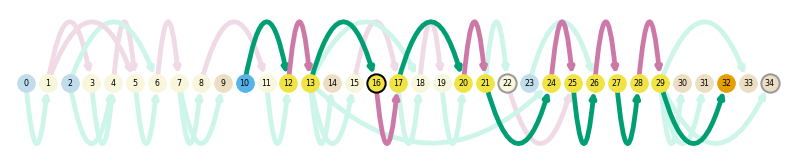

In [60]:
sg.plot_transcript_path('ENSMUSG00000059326[4,9,1]', indicate_novel=True)

In [49]:
# sg.adata.obs.head()

In [47]:
make_reports(sg, 'Ncs1')


Plotting transcripts for ENSMUSG00000062661
Saving transcript path graph for ENSMUSG00000062661[1,1,1] as figures/Ncs1_novel_ENSMUSG00000062661[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000062661[3,3,4] as figures/Ncs1_novel_ENSMUSG00000062661[3,3,4]_path.png
Saving transcript path graph for ENSMUSG00000062661[3,3,1] as figures/Ncs1_novel_ENSMUSG00000062661[3,3,1]_path.png
Saving transcript path graph for ENSMUSG00000062661[1,4,3] as figures/Ncs1_novel_ENSMUSG00000062661[1,4,3]_path.png
Generating report for ENSMUSG00000062661

Plotting transcripts for ENSMUSG00000062661
Saving transcript path graph for ENSMUSG00000062661[1,1,1] as figures/Ncs1_browser_ENSMUSG00000062661[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000062661[3,3,4] as figures/Ncs1_browser_ENSMUSG00000062661[3,3,4]_path.png
Saving transcript path graph for ENSMUSG00000062661[3,3,1] as figures/Ncs1_browser_ENSMUSG00000062661[3,3,1]_path.png
Saving transcript path graph for ENSMUSG00000062661

In [48]:
g = 'Adcy1'
make_reports(sg, g)


Plotting transcripts for ENSMUSG00000020431
Saving transcript path graph for ENSMUSG00000020431[4,3,1] as figures/Adcy1_novel_ENSMUSG00000020431[4,3,1]_path.png
Saving transcript path graph for ENSMUSG00000020431[3,3,1] as figures/Adcy1_novel_ENSMUSG00000020431[3,3,1]_path.png
Saving transcript path graph for ENSMUSG00000020431[3,3,4] as figures/Adcy1_novel_ENSMUSG00000020431[3,3,4]_path.png
Saving transcript path graph for ENSMUSG00000020431[1,1,1] as figures/Adcy1_novel_ENSMUSG00000020431[1,1,1]_path.png
Generating report for ENSMUSG00000020431

Plotting transcripts for ENSMUSG00000020431
Saving transcript path graph for ENSMUSG00000020431[4,3,1] as figures/Adcy1_browser_ENSMUSG00000020431[4,3,1]_path.png
Saving transcript path graph for ENSMUSG00000020431[3,3,1] as figures/Adcy1_browser_ENSMUSG00000020431[3,3,1]_path.png
Saving transcript path graph for ENSMUSG00000020431[3,3,4] as figures/Adcy1_browser_ENSMUSG00000020431[3,3,4]_path.png
Saving transcript path graph for ENSMUSG0000

In [50]:
g = 'Spry2'
make_reports(sg, g)


Plotting transcripts for ENSMUSG00000022114
Saving transcript path graph for ENSMUSG00000022114[2,2,1] as figures/Spry2_novel_ENSMUSG00000022114[2,2,1]_path.png
Saving transcript path graph for ENSMUSG00000022114[1,1,1] as figures/Spry2_novel_ENSMUSG00000022114[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000022114[3,3,2] as figures/Spry2_novel_ENSMUSG00000022114[3,3,2]_path.png
Saving transcript path graph for ENSMUSG00000022114[2,2,3] as figures/Spry2_novel_ENSMUSG00000022114[2,2,3]_path.png
Generating report for ENSMUSG00000022114

Plotting transcripts for ENSMUSG00000022114
Saving transcript path graph for ENSMUSG00000022114[2,2,1] as figures/Spry2_browser_ENSMUSG00000022114[2,2,1]_path.png
Saving transcript path graph for ENSMUSG00000022114[1,1,1] as figures/Spry2_browser_ENSMUSG00000022114[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000022114[3,3,2] as figures/Spry2_browser_ENSMUSG00000022114[3,3,2]_path.png
Saving transcript path graph for ENSMUSG0000

In [52]:
g = 'Wasf2'
make_reports(sg, g)


Plotting transcripts for ENSMUSG00000028868
Saving transcript path graph for ENSMUSG00000028868[1,8,6] as figures/Wasf2_novel_ENSMUSG00000028868[1,8,6]_path.png
Saving transcript path graph for ENSMUSG00000028868[8,7,2] as figures/Wasf2_novel_ENSMUSG00000028868[8,7,2]_path.png
Saving transcript path graph for ENSMUSG00000028868[1,1,2] as figures/Wasf2_novel_ENSMUSG00000028868[1,1,2]_path.png
Generating report for ENSMUSG00000028868

Plotting transcripts for ENSMUSG00000028868
Saving transcript path graph for ENSMUSG00000028868[1,8,6] as figures/Wasf2_browser_ENSMUSG00000028868[1,8,6]_path.png
Saving transcript path graph for ENSMUSG00000028868[8,7,2] as figures/Wasf2_browser_ENSMUSG00000028868[8,7,2]_path.png
Saving transcript path graph for ENSMUSG00000028868[1,1,2] as figures/Wasf2_browser_ENSMUSG00000028868[1,1,2]_path.png
Generating report for ENSMUSG00000028868


In [19]:
sg.ic_adata.var.head()

,gid,gname,ic_name
ic_id,,,
ENSG00000000003_1,ENSG00000000003,TSPAN6,TSPAN6_1
ENSG00000000003_10,ENSG00000000003,TSPAN6,TSPAN6_10
ENSG00000000003_11,ENSG00000000003,TSPAN6,TSPAN6_11
ENSG00000000003_12,ENSG00000000003,TSPAN6,TSPAN6_12
ENSG00000000003_2,ENSG00000000003,TSPAN6,TSPAN6_2
